In [ ]:
!gdown --id 1WZVnsI-92uLbSZG-AG10PW11_8oR-R-5
!unzip AirlinePassengerSatisfaction.zip -d AirlinePassengerSatisfaction

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1WZVnsI-92uLbSZG-AG10PW11_8oR-R-5
To: /content/AirlinePassengerSatisfaction.zip
100% 2.84M/2.84M [00:00<00:00, 42.0MB/s]
Archive:  AirlinePassengerSatisfaction.zip
  inflating: AirlinePassengerSatisfaction/test.csv  
  inflating: AirlinePassengerSatisfaction/train.csv  


# Install and import necessary packages

## Install packages

In [ ]:
!pip install pyspark
!pip install findspark
!pip install pandas

## Import Libraries

In [ ]:
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import random

from pyspark.sql.functions import col, sum as spark_sum, when, collect_list, collect_set, udf, countDistinct, monotonically_increasing_id, row_number, rand
from pyspark.ml import Transformer, Pipeline
from pyspark.ml.param.shared import Param, Params, TypeConverters
from pyspark.sql.types import IntegerType, ArrayType, FloatType, DoubleType
from pyspark import keyword_only
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.linalg import VectorUDT
from pyspark.ml.feature import StandardScaler, VectorAssembler, Imputer, StringIndexer, RobustScaler, OneHotEncoder, PCA
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.window import Window

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Set up Spark and Read data

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession

# Initialize a Spark Session
spark = SparkSession\
    .builder\
    .appName("AirlinePassengerSatisfaction")\
    .config("spark.sql.execution.arrow.pyspark.enabled", "true")\
    .getOrCreate()

# Check if the Spark Session is active
if 'spark' in locals() and isinstance(spark, SparkSession):
    print("SparkSession is active and ready to use.")
else:
    print("SparkSession is not active. Please create a SparkSession.")

SparkSession is active and ready to use.


In [ ]:
# Load train file
train = spark.read.csv(
    "/content/AirlinePassengerSatisfaction/train.csv",
    header=True,
    inferSchema=True
)
# Load test file
test = spark.read.csv(
    "/content/AirlinePassengerSatisfaction/test.csv",
    header=True,
    inferSchema=True
)

In [ ]:
train.show(5, truncate=False)
test.show(5, truncate=False)

+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+-----------------------+
|_c0|id    |Gender|Customer Type    |Age|Type of Travel |Class   |Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction           |
+---+------+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+---------

# Airline Passenger EDA

## Define functions

In [ ]:
# Function to get number rows for each column
def count_rowncol(df):
  print(type(df), "\nNumber of Rows: ", df.count(), "\nNumber of Columns: ", len(df.columns))

# Function to get null values for each column
def count_null(df):
  null_counts = df.select([
      spark_sum(when(col(c).isNull() | (col(c) == ""), 1).otherwise(0)).alias(c)
      for c in df.columns
      ])
  null_counts.show(truncate=False)

# Function to get unique values for each column
def unique_values(df):
    unique_dict = {}
    for col_name in df.columns:
        unique = df.select(collect_set(col_name).alias("unique_values")).collect()
        unique_dict[col_name] = unique[0]["unique_values"]
    return unique_dict

# Sort the type of variables
def variable_type(df):
    types_list = df.dtypes
    str_variables = []
    int_variables = []
    for i in types_list:
        if i[1] == "string" and i[0]:
            str_variables.append(i[0])
        else:
            int_variables.append(i[0])
    return str_variables, int_variables

## Explore The Schema


In [ ]:
# Checking numbers of rows and columns in each dataset:
print("Train dataset:")
count_rowncol(train)
print()
print("Test dataset:")
count_rowncol(test)
print()

# The typical schema of our dataset:
train.printSchema()

Train dataset:
<class 'pyspark.sql.dataframe.DataFrame'> 
Number of Rows:  103904 
Number of Columns:  25

Test dataset:
<class 'pyspark.sql.dataframe.DataFrame'> 
Number of Rows:  25976 
Number of Columns:  25

root
 |-- _c0: integer (nullable = true)
 |-- id: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Customer Type: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Type of Travel: string (nullable = true)
 |-- Class: string (nullable = true)
 |-- Flight Distance: integer (nullable = true)
 |-- Inflight wifi service: integer (nullable = true)
 |-- Departure/Arrival time convenient: integer (nullable = true)
 |-- Ease of Online booking: integer (nullable = true)
 |-- Gate location: integer (nullable = true)
 |-- Food and drink: integer (nullable = true)
 |-- Online boarding: integer (nullable = true)
 |-- Seat comfort: integer (nullable = true)
 |-- Inflight entertainment: integer (nullable = true)
 |-- On-board service: integer (nullable = tru

## EDA in Pandas

In [ ]:
# Load train file using pandas
pd_df = pd.read_csv(
    "/content/AirlinePassengerSatisfaction/train.csv"
)

# Load test file using pandas
test_df = pd.read_csv(
    "/content/AirlinePassengerSatisfaction/test.csv"
)
pd_df.head()

,Unnamed: 0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,70172,Male,Loyal Customer,13,Personal Travel,Eco Plus,460,3,4,...,5,4,3,4,4,5,5,25,18.0,neutral or dissatisfied
1,1,5047,Male,disloyal Customer,25,Business travel,Business,235,3,2,...,1,1,5,3,1,4,1,1,6.0,neutral or dissatisfied
2,2,110028,Female,Loyal Customer,26,Business travel,Business,1142,2,2,...,5,4,3,4,4,4,5,0,0.0,satisfied
3,3,24026,Female,Loyal Customer,25,Business travel,Business,562,2,5,...,2,2,5,3,1,4,2,11,9.0,neutral or dissatisfied
4,4,119299,Male,Loyal Customer,61,Business travel,Business,214,3,3,...,3,3,4,4,3,3,3,0,0.0,satisfied


### Heat Map

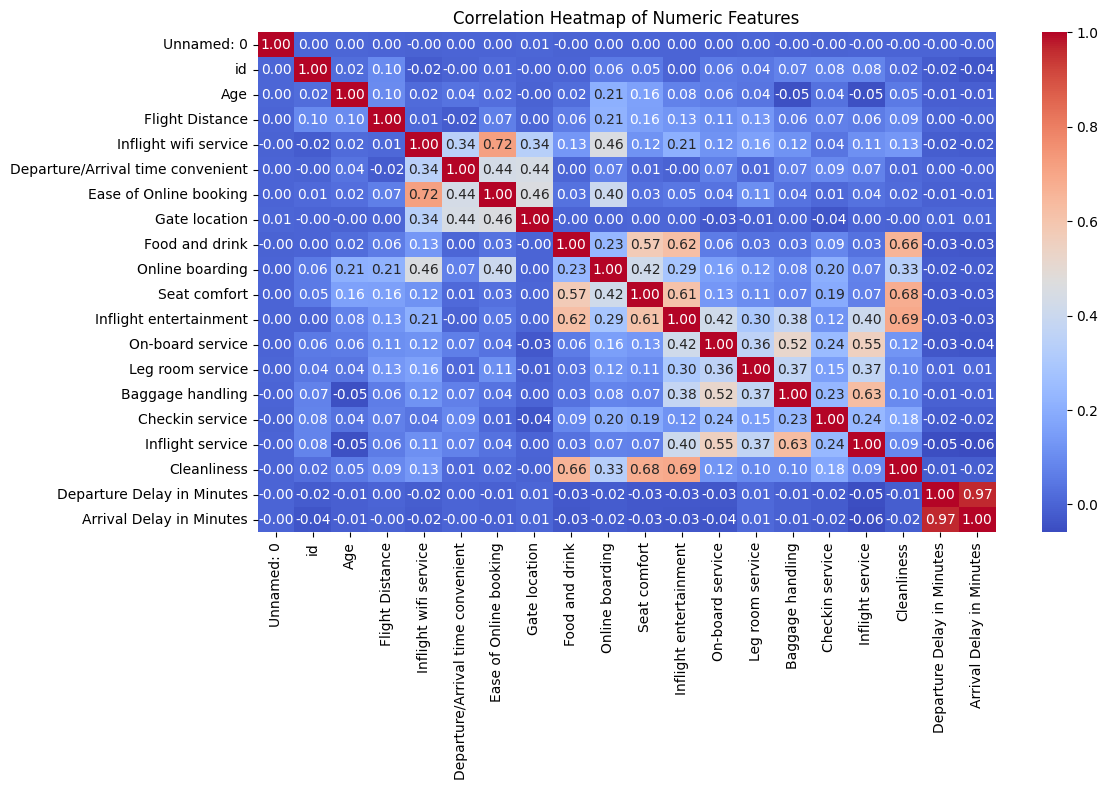

In [ ]:
plt.figure(figsize=(12, 8))
sns.heatmap(pd_df.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()


### Bar Chart

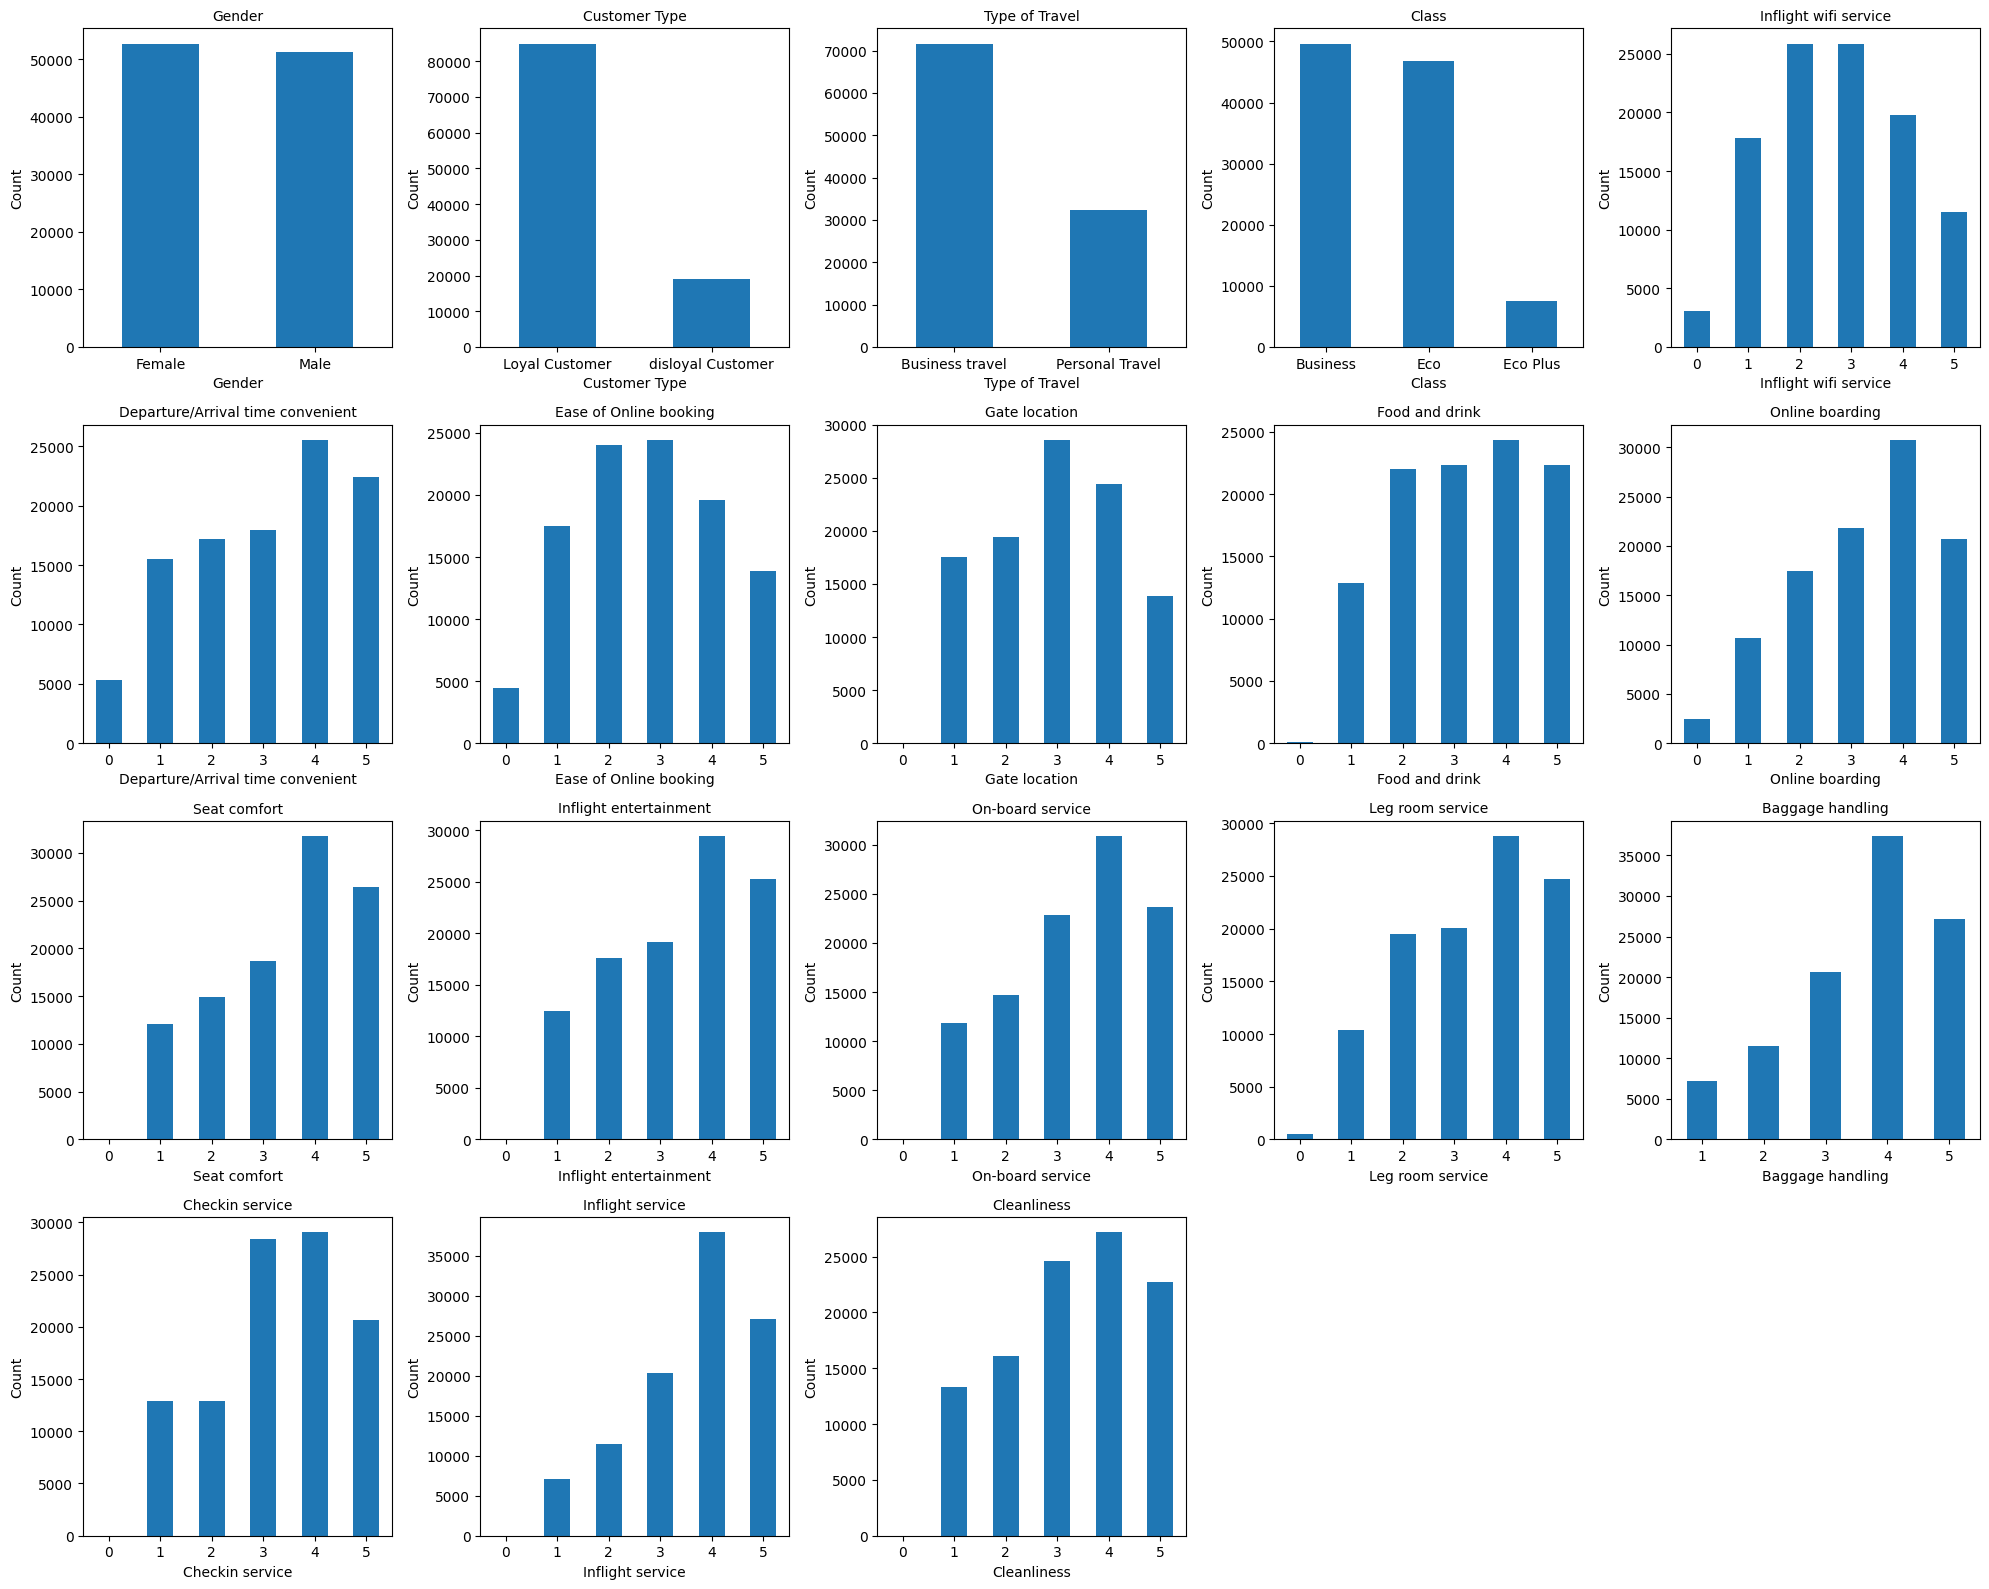

In [ ]:
# Feature Selection
categorical_variables_str = ['Gender', 'Customer Type', 'Type of Travel', 'Class']
categorical_variables_int = ['Inflight wifi service', 'Departure/Arrival time convenient',
                             'Ease of Online booking', 'Gate location', 'Food and drink',
                             'Online boarding', 'Seat comfort', 'Inflight entertainment',
                             'On-board service', 'Leg room service', 'Baggage handling',
                             'Checkin service', 'Inflight service', 'Cleanliness']

cols_to_plot = categorical_variables_str + categorical_variables_int
n_plots = len(cols_to_plot)
rows, cols = 4, 5

fig, axes = plt.subplots(rows, cols, figsize=(20, 16))  # Adjust figsize as needed
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    value_counts = pd_df[col].value_counts(dropna=False).sort_index()
    value_counts.plot(kind='bar', ax=axes[i])
    axes[i].set_title(f"{col}", fontsize=10)
    axes[i].set_ylabel("Count")
    axes[i].set_xlabel(col)
    axes[i].tick_params(axis='x', labelrotation=0)

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


### Pie Chart

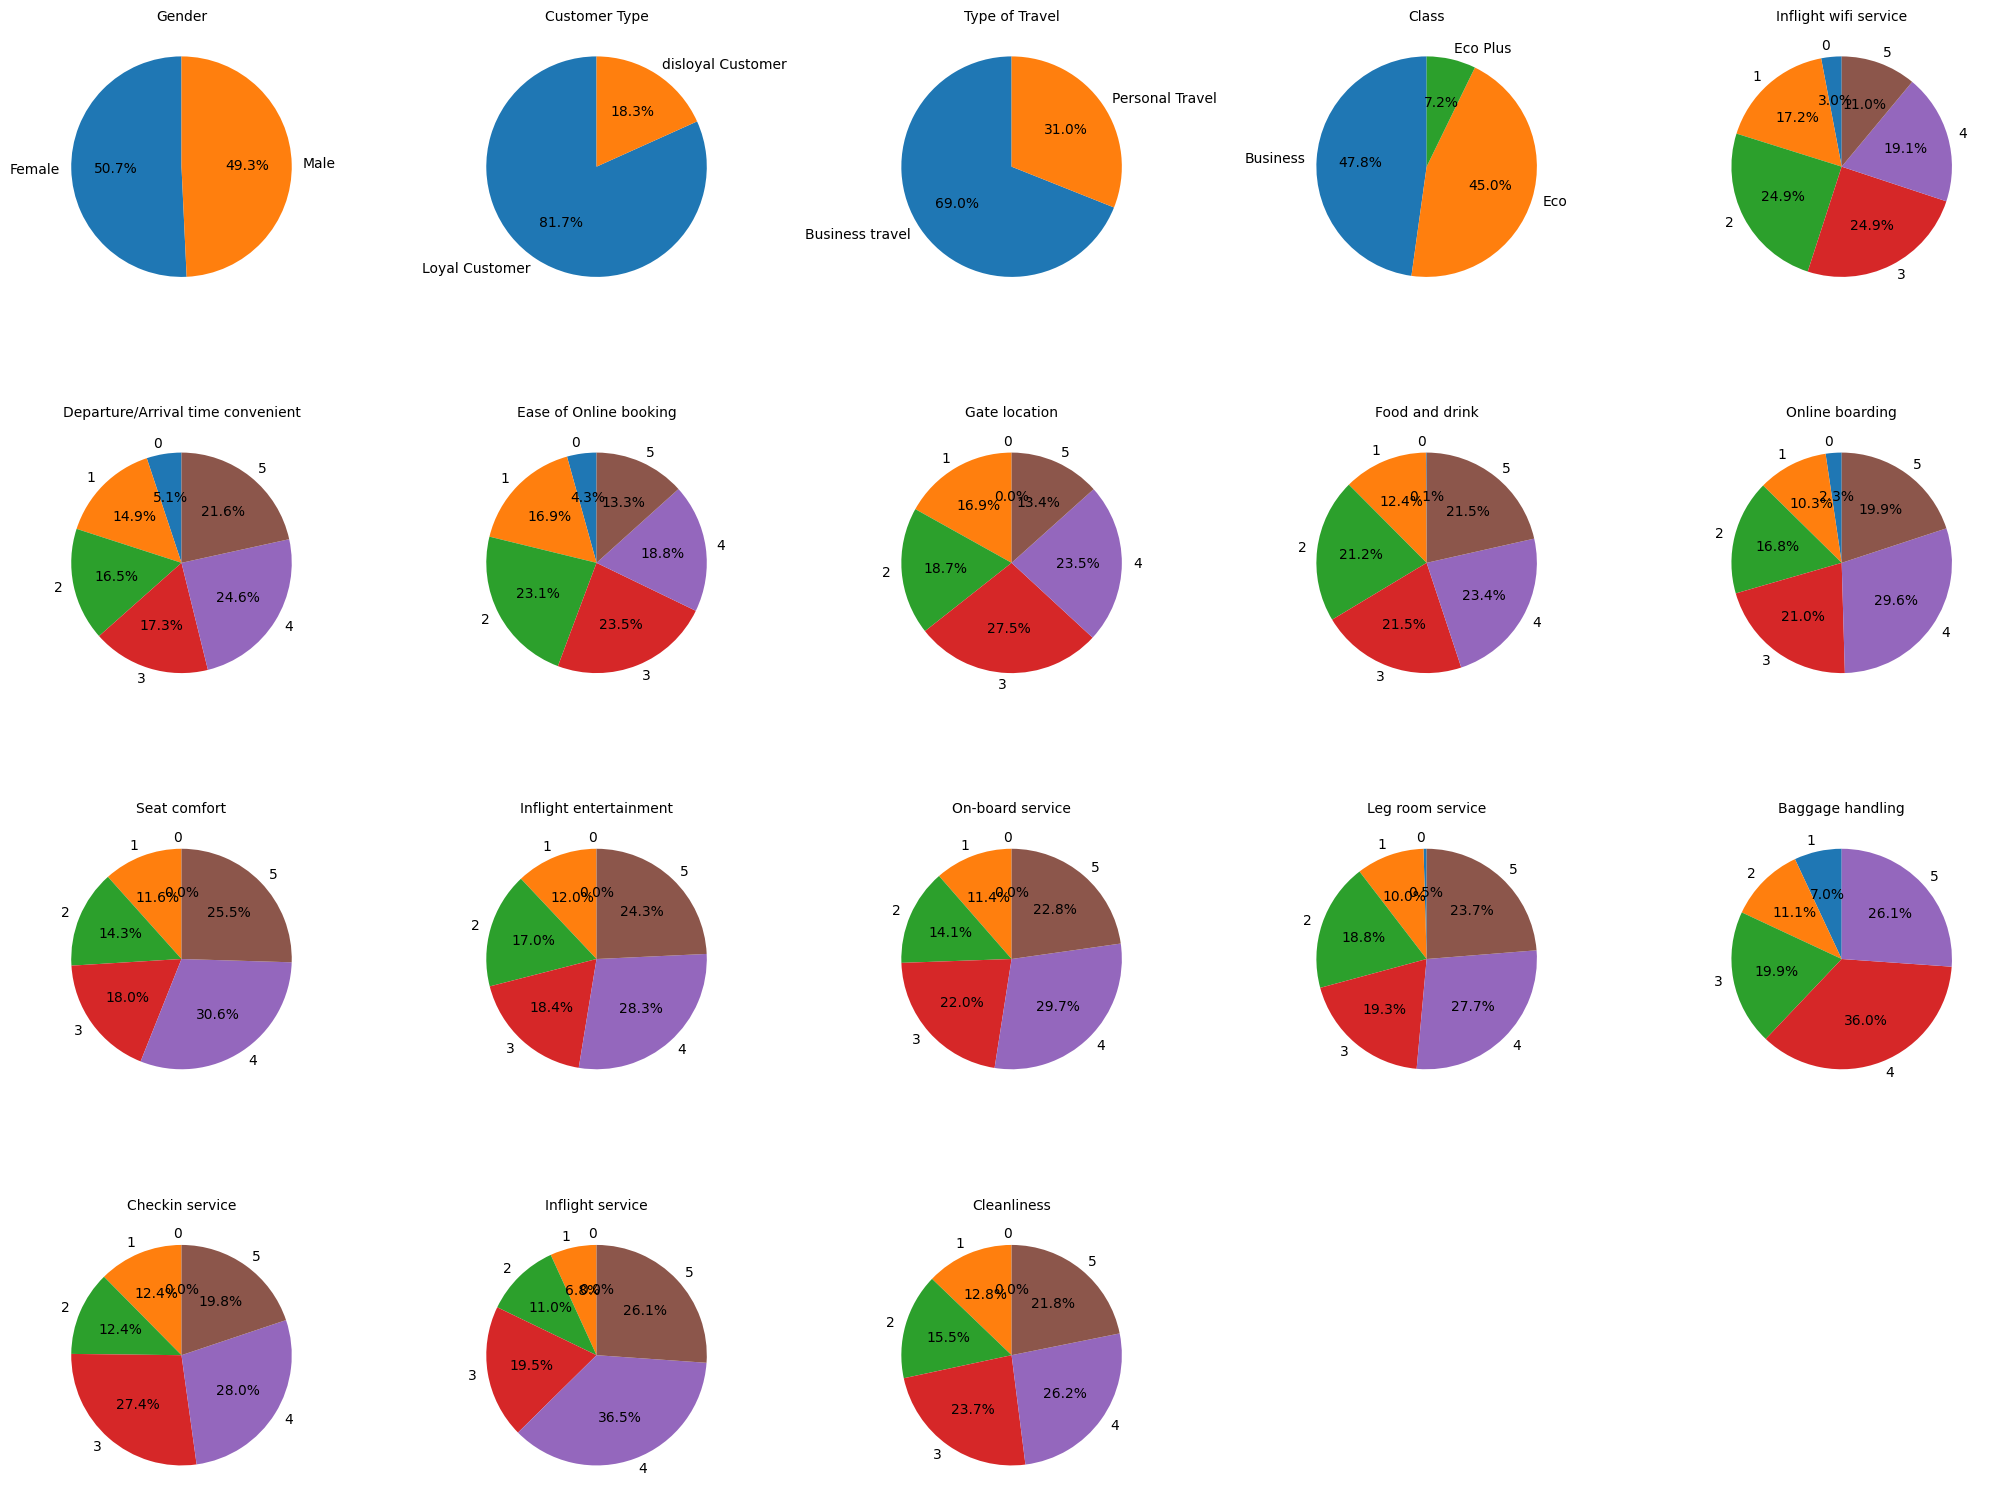

In [ ]:
cols_to_plot = categorical_variables_str + categorical_variables_int
n_plots = len(cols_to_plot)
rows, cols = 4, 5

fig, axes = plt.subplots(rows, cols, figsize=(20, 16))
axes = axes.flatten()

for i, col in enumerate(cols_to_plot):
    value_counts = pd_df[col].value_counts(dropna=False).sort_index()
    axes[i].pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90)
    axes[i].set_title(f"{col}", fontsize=10)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


Some conclusions about the considered sample:
*   The sample contains a roughly equal number of male and female
passengers.

*   A significant majority of customers are returning or loyal flyers.

*   Most passengers traveled for business rather than leisure purposes.

*   Approximately half of the travelers were seated in business class.

*   Over 60% of passengers expressed satisfaction with the baggage handling service, giving it a rating of 4 or 5 out of 5.

*   More than half of the passengers found their seats to be comfortable, rating them 4 or 5 out of 5.

### Relationship Between 'Class' and 'satisfaction'

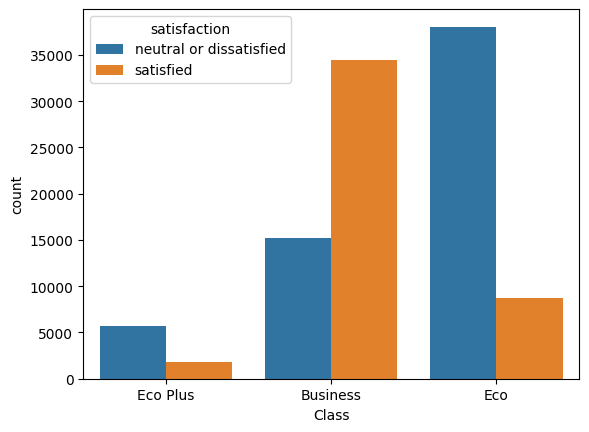

In [ ]:
sns.countplot(x = 'Class', hue = 'satisfaction', data = pd_df)
plt.show()

The chart shows that most economy and economy plus passengers were dissatisfied, while business class passengers were generally satisfied.

### Age Distribution

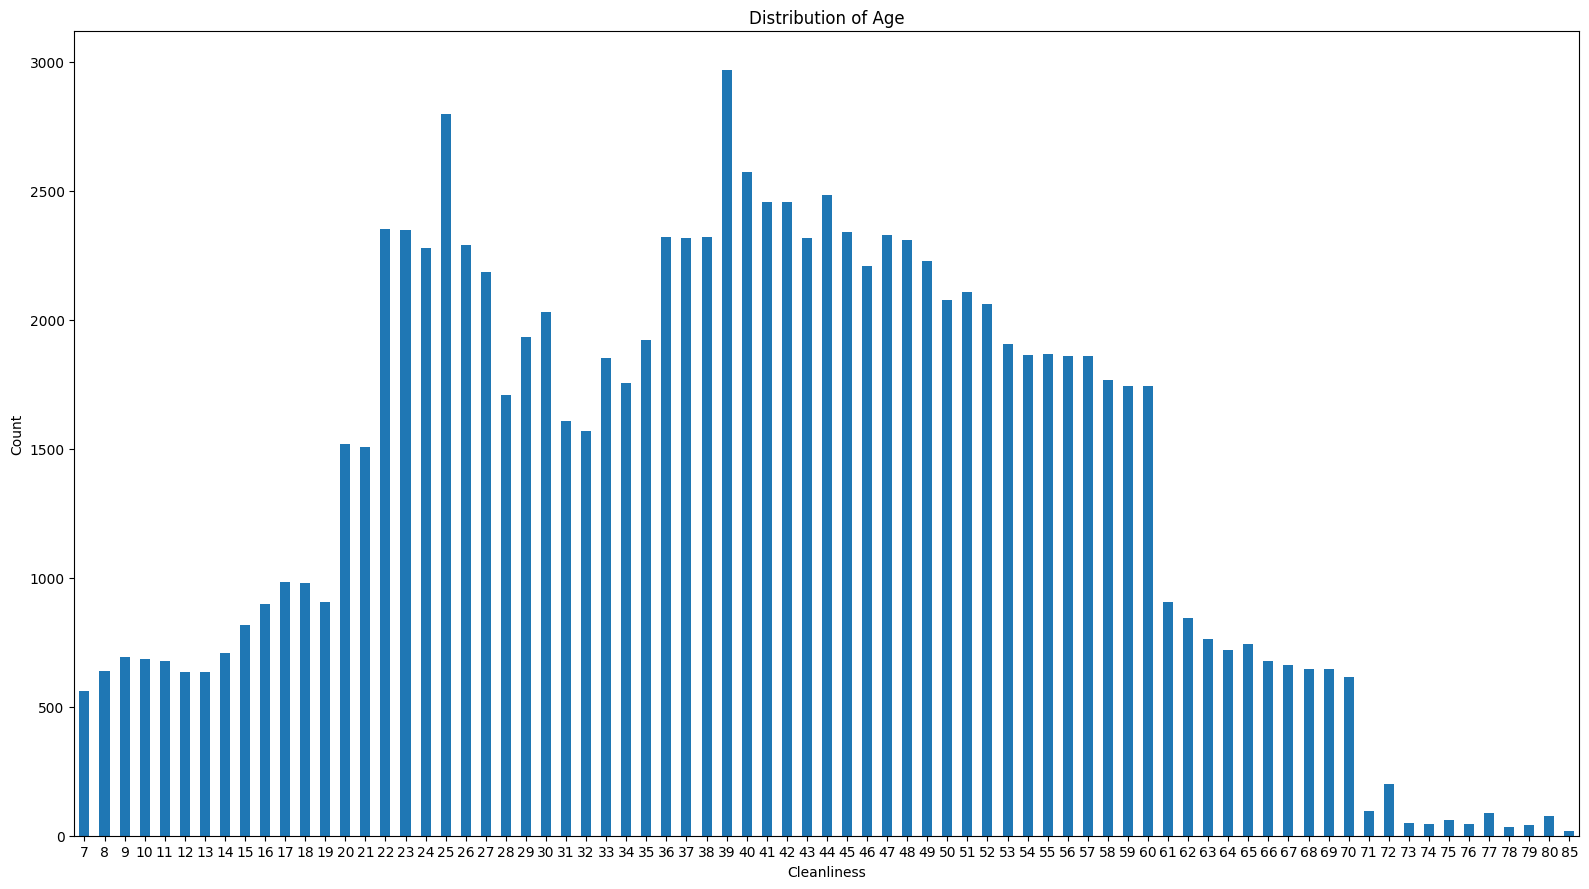

In [ ]:
plt.figure(figsize=(16, 9))
value_counts = pd_df["Age"].value_counts(dropna=False).sort_index()
value_counts.plot(kind='bar')
plt.title(f"Distribution of Age")
plt.ylabel("Count")
plt.xlabel(col)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

### Relationship Between 'Arrival Delay in Minutes' and 'Departure Delay in Minutes'

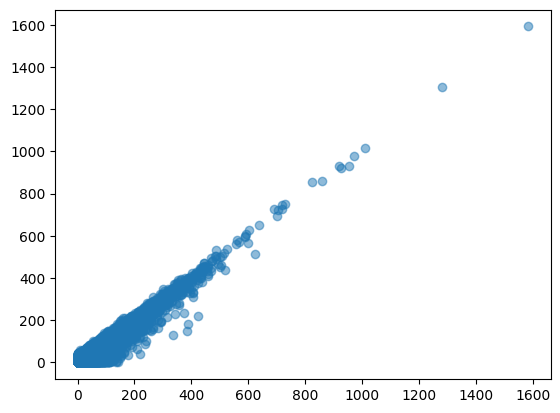

In [ ]:
plt.scatter(pd_df['Arrival Delay in Minutes'], pd_df['Departure Delay in Minutes'], alpha = 0.5)

The points form a roughly straight line from lower left to upper right, suggesting a linear relationship between departure and arrival delays. This makes sense, as delays at departure typically result in similar delays at arrival unless the flight makes up time en route.


# EDA test file

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Clean and prepare data
df_clean = test.toPandas()
df_clean.head()

,_c0,id,Gender,Customer Type,Age,Type of Travel,Class,Flight Distance,Inflight wifi service,Departure/Arrival time convenient,...,Inflight entertainment,On-board service,Leg room service,Baggage handling,Checkin service,Inflight service,Cleanliness,Departure Delay in Minutes,Arrival Delay in Minutes,satisfaction
0,0,19556,Female,Loyal Customer,52,Business travel,Eco,160,5,4,...,5,5,5,5,2,5,5,50,44.0,satisfied
1,1,90035,Female,Loyal Customer,36,Business travel,Business,2863,1,1,...,4,4,4,4,3,4,5,0,0.0,satisfied
2,2,12360,Male,disloyal Customer,20,Business travel,Eco,192,2,0,...,2,4,1,3,2,2,2,0,0.0,neutral or dissatisfied
3,3,77959,Male,Loyal Customer,44,Business travel,Business,3377,0,0,...,1,1,1,1,3,1,4,0,6.0,satisfied
4,4,36875,Female,Loyal Customer,49,Business travel,Eco,1182,2,3,...,2,2,2,2,4,2,4,0,20.0,satisfied


<ipython-input-38-620300df0e10>:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_clean['Arrival Delay in Minutes'].fillna(df_clean['Arrival Delay in Minutes'].median(), inplace=True)


<Figure size 1000x600 with 0 Axes>

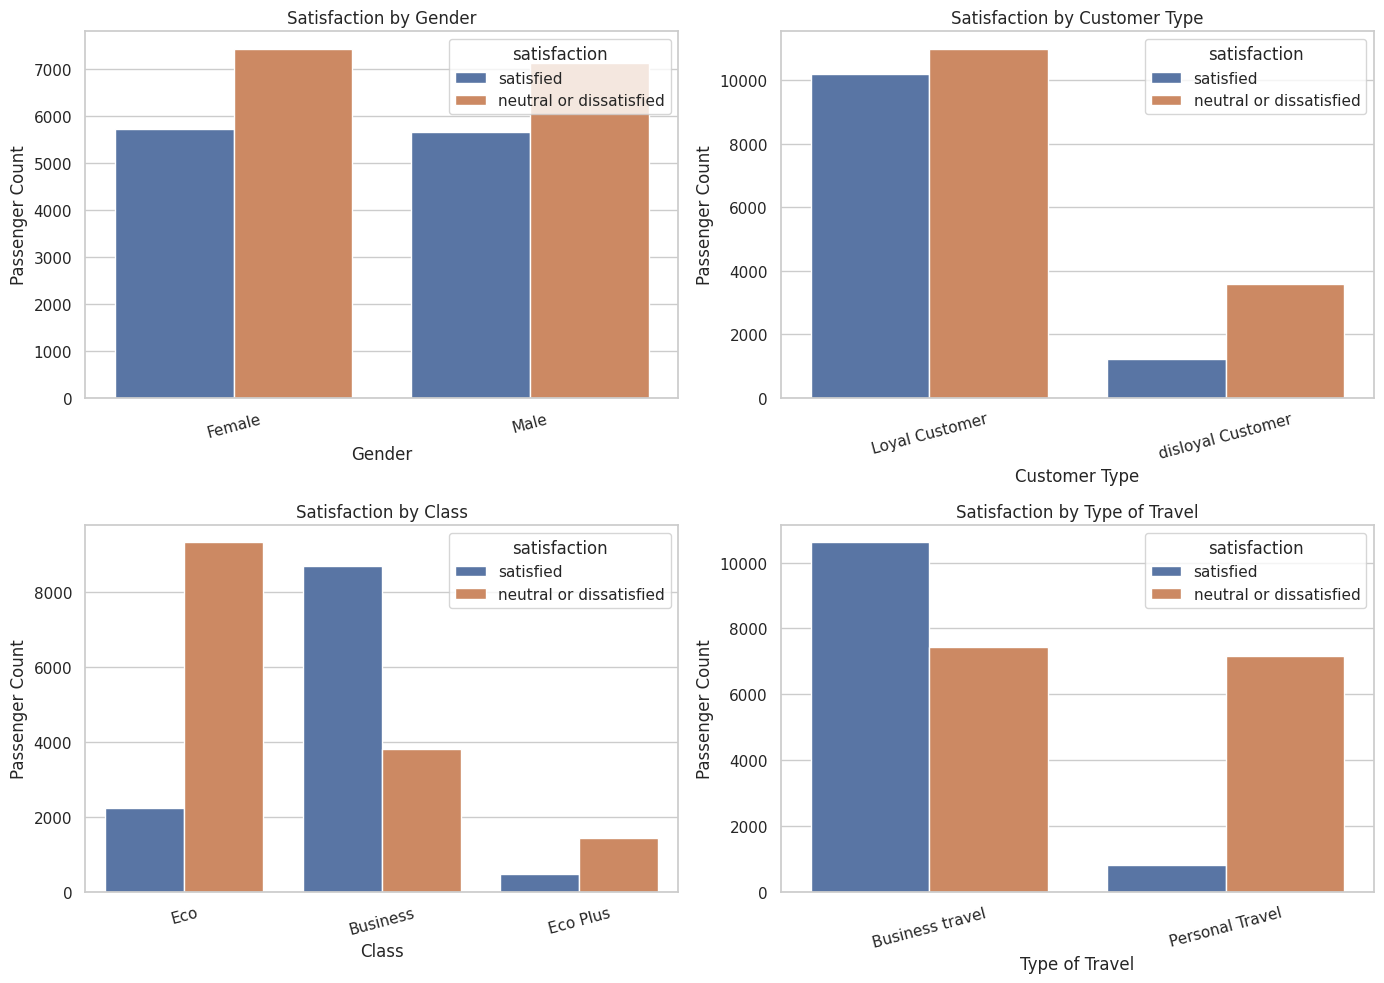

<ipython-input-38-620300df0e10>:61: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


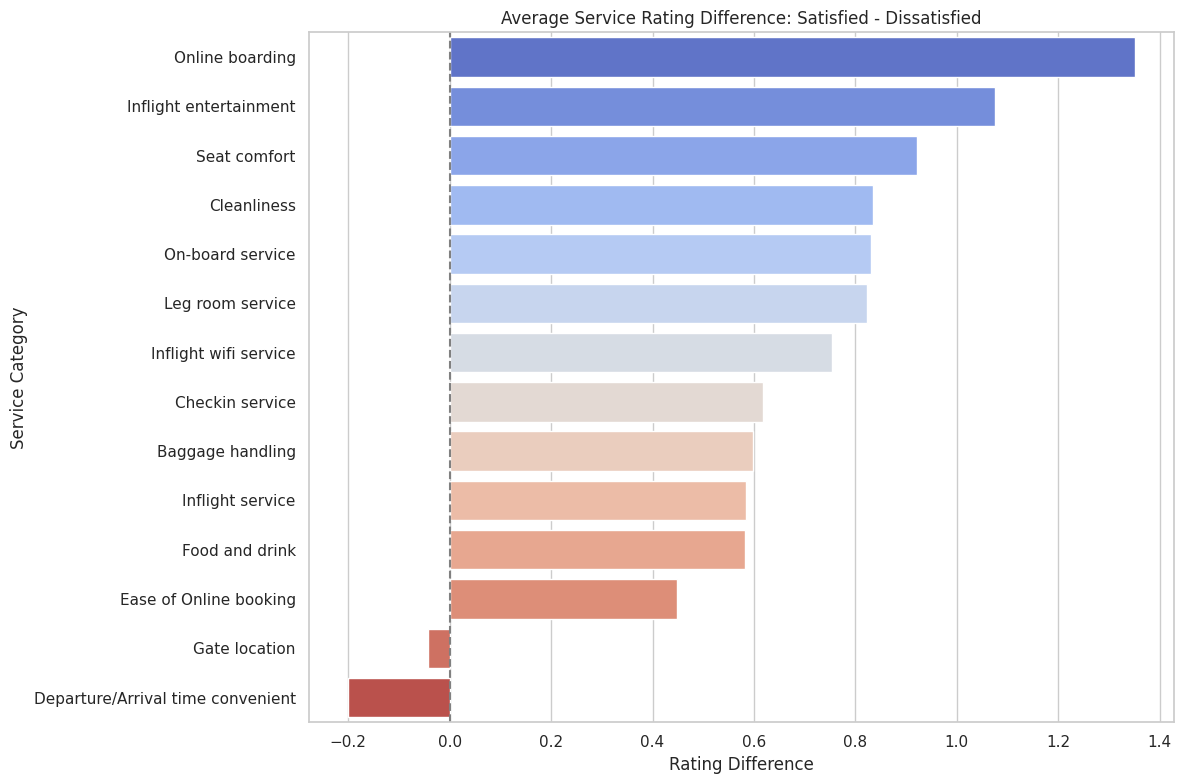

<Figure size 800x500 with 0 Axes>

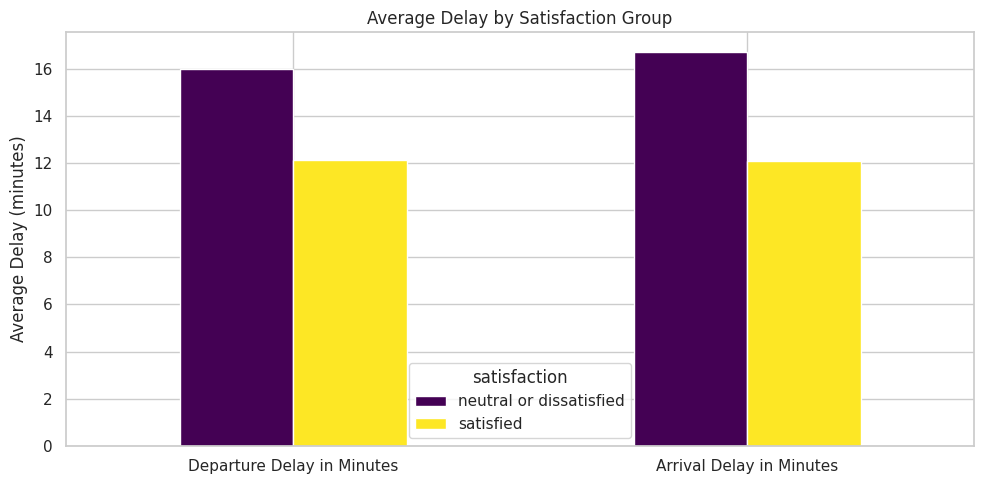

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Clean and prepare data
df_clean = test.toPandas()

# Drop unnecessary columns
df_clean.drop(columns=['_c0', 'id'], inplace=True)

# Check and fill missing values in 'Arrival Delay in Minutes'
df_clean['Arrival Delay in Minutes'].fillna(df_clean['Arrival Delay in Minutes'].median(), inplace=True)

# Step A: Customer Profile Analysis
# Satisfaction by Gender, Customer Type, Class, Type of Travel
profile_vars = ['Gender', 'Customer Type', 'Class', 'Type of Travel']

profile_summary = {}
for var in profile_vars:
    profile_summary[var] = df_clean.groupby([var, 'satisfaction']).size().unstack().fillna(0)

# Age distribution by satisfaction
age_dist = df_clean[['Age', 'satisfaction']]

# Step B: Service Ratings vs Satisfaction
service_columns = [
    'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
    'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
    'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling',
    'Checkin service', 'Inflight service', 'Cleanliness'
]

service_summary = df_clean.groupby('satisfaction')[service_columns].mean().T
service_summary['Difference'] = service_summary['satisfied'] - service_summary['neutral or dissatisfied']
service_summary_sorted = service_summary.sort_values(by='Difference', ascending=False)

# Step C: Delay analysis
delay_summary = df_clean.groupby('satisfaction')[['Departure Delay in Minutes', 'Arrival Delay in Minutes']].mean()

# Set plot style
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# 1. Customer Profile Plots
fig1, axes = plt.subplots(2, 2, figsize=(14, 10))
profile_vars = ['Gender', 'Customer Type', 'Class', 'Type of Travel']

for ax, var in zip(axes.flat, profile_vars):
    sns.countplot(data=df_clean, x=var, hue='satisfaction', ax=ax)
    ax.set_title(f'Satisfaction by {var}')
    ax.set_ylabel("Passenger Count")
    ax.set_xlabel(var)
    ax.tick_params(axis='x', rotation=15)

plt.tight_layout()
plt.show()

# 2. Service Rating Difference Plot
plt.figure(figsize=(12, 8))
sns.barplot(
    y=service_summary_sorted.index,
    x=service_summary_sorted['Difference'],
    palette='coolwarm'
)
plt.axvline(0, color='gray', linestyle='--')
plt.title('Average Service Rating Difference: Satisfied - Dissatisfied')
plt.xlabel('Rating Difference')
plt.ylabel('Service Category')
plt.tight_layout()
plt.show()

# 3. Delay Analysis Plot
plt.figure(figsize=(8, 5))
delay_summary.T.plot(kind='bar', figsize=(10, 5), colormap='viridis')
plt.title('Average Delay by Satisfaction Group')
plt.ylabel('Average Delay (minutes)')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Preprocess

## Checking Null Values

In [ ]:
from pyspark.sql.functions import col, sum as spark_sum
# Checking null values of Train dataset
print("The null values in Train dataset:")
count_null(train)

The null values in Train dataset:
+---+---+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+------------+
|_c0|id |Gender|Customer Type|Age|Type of Travel|Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction|
+---+---+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+-

In [ ]:
# Define a function to find the best imputation strategy for a column
def find_best_imputation_strategy(df, col_name, strategy_options=["mean", "median"]):
    """
    Finds the best imputation strategy (mean, median, or mode) for a given column
    by evaluating which one minimizes the standard deviation of the column after imputation.
    This is a heuristic and might not be the best strategy for all scenarios.
    """
    original_std = df.select(col_name).agg({'`{}`'.format(col_name): 'stddev'}).collect()[0][0]
    print(f"Original standard deviation of '{col_name}': {original_std}")
    best_strategy = None
    min_std_diff = float('inf')

    for strategy in strategy_options:
        imputer = Imputer(inputCols=[col_name], outputCols=[col_name], strategy=strategy)
        try:
            model = imputer.fit(df)
            df_imputed = model.transform(df)
            imputed_std = df_imputed.select(col_name).agg({'`{}`'.format(col_name): 'stddev'}).collect()[0][0]
            #print(f"Standard deviation after imputation with '{strategy}': {imputed_std}")

            if imputed_std is not None and original_std is not None:
                std_diff = abs(imputed_std - original_std)
                if std_diff < min_std_diff:
                    min_std_diff = std_diff
                    #print(f"New minimum standard deviation difference: {min_std_diff}")
                    best_strategy = strategy
        except Exception as e:
            print(f"Could not apply strategy '{strategy}' to column '{col_name}': {e}")
            continue

    return best_strategy

In [ ]:
# Columns with null values identified from previous count_null output
columns_to_impute = ['Arrival Delay in Minutes']

# Impute null values in the train dataset
print("\nImputing null values in the train dataset...")
for col_name in columns_to_impute:
    best_strategy_train = find_best_imputation_strategy(train, col_name, strategy_options=["mean", "median"])
    if best_strategy_train:
        print(f"Best imputation strategy for '{col_name}' in train: {best_strategy_train}")
        imputer = Imputer(inputCols=[col_name], outputCols=[col_name], strategy=best_strategy_train)
        model = imputer.fit(train)
        train = model.transform(train)
    else:
        print(f"Could not find a suitable strategy for '{col_name}' in train.")

print("\nChecking null values of Train dataset after imputation:")
count_null(train)


Imputing null values in the train dataset...
Original standard deviation of 'Arrival Delay in Minutes': 38.698682020966515
Best imputation strategy for 'Arrival Delay in Minutes' in train: median

Checking null values of Train dataset after imputation:
+---+---+------+-------------+---+--------------+-----+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+------------+
|_c0|id |Gender|Customer Type|Age|Type of Travel|Class|Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes

## Checking Outliers

In [ ]:
# Function to detect and replace outliers with the mean using IQR
def check_outlier(df, col_name):
    print(f"\nProcessing column: {col_name}")
    # Calculate Q1, Q3, and IQR
    quartiles = df.approxQuantile(col_name, [0.25, 0.75], 0.05)
    Q1 = quartiles[0]
    Q3 = quartiles[1]
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    print(f"  Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f"  Lower Bound (IQR method): {lower_bound}")
    print(f"  Upper Bound (IQR method): {upper_bound}")

    # Identify outliers
    is_outlier_col = (col(col_name) < lower_bound) | (col(col_name) > upper_bound)
    outliers_count = df.filter(is_outlier_col).count()
    total_count = df.count()
    print(f"  Number of outliers detected: {outliers_count} ({outliers_count/total_count:.2%})")

    return df

In [ ]:
numeric_columns_for_outlier_check = ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']

total_column = numeric_columns_for_outlier_check

# Apply outlier replacement to the selected numerical columns in the training data
for col_name in total_column:
    train = check_outlier(train, col_name)


Processing column: Age
  Q1: 27.0, Q3: 50.0, IQR: 23.0
  Lower Bound (IQR method): -7.5
  Upper Bound (IQR method): 84.5
  Number of outliers detected: 17 (0.02%)

Processing column: Flight Distance
  Q1: 421.0, Q3: 1572.0, IQR: 1151.0
  Lower Bound (IQR method): -1305.5
  Upper Bound (IQR method): 3298.5
  Number of outliers detected: 5899 (5.68%)

Processing column: Departure Delay in Minutes
  Q1: 0.0, Q3: 9.0, IQR: 9.0
  Lower Bound (IQR method): -13.5
  Upper Bound (IQR method): 22.5
  Number of outliers detected: 18381 (17.69%)

Processing column: Arrival Delay in Minutes
  Q1: 0.0, Q3: 10.0, IQR: 10.0
  Lower Bound (IQR method): -15.0
  Upper Bound (IQR method): 25.0
  Number of outliers detected: 16994 (16.36%)


## Build pipeline

In [ ]:
df = train

# Drop columns id and numbers
columns_to_drop = ["_c0"]
df = df.drop(*columns_to_drop)

# Displaying basic statistics
df.describe().show(truncate=False)

# Checking Distinct values in train dataset
print("Distinct values check: ")
df.select([countDistinct(c) for c in df.columns]).show()

#Checking unique values
unique_values_dict = unique_values(df)
for column, values in unique_values_dict.items():
    print(f"Column: {column}, Unique Values: {values}")

# Show dataframe
df.show(5, truncate=False)

+-------+-----------------+------+-----------------+------------------+---------------+--------+------------------+---------------------+---------------------------------+----------------------+------------------+------------------+------------------+------------------+----------------------+-----------------+------------------+------------------+------------------+------------------+------------------+--------------------------+------------------------+-----------------------+
|summary|id               |Gender|Customer Type    |Age               |Type of Travel |Class   |Flight Distance   |Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location     |Food and drink    |Online boarding   |Seat comfort      |Inflight entertainment|On-board service |Leg room service  |Baggage handling  |Checkin service   |Inflight service  |Cleanliness       |Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction           |
+-------+-----------------+------+

In [ ]:
# Feature Selection
target_variable = ["satisfaction"]
numeric_variables = ["Age", "Flight Distance", "Departure Delay in Minutes", "Arrival Delay in Minutes"]
categorical_variables_str = [col for col in variable_type(df)[0] if col != "satisfaction"]
categorical_variables_int = [
    c for c in df.columns
        if c not in numeric_variables + categorical_variables_str + ["_c0", "id"] and c != "satisfaction"
]

print("Categorical variables in int: ", categorical_variables_int)
print("Categorical variables in str: ", categorical_variables_str)
print("Numeric variables: ", numeric_variables)
print("Target variable: ", target_variable)

Categorical variables in int:  ['Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking', 'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort', 'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling', 'Checkin service', 'Inflight service', 'Cleanliness']
Categorical variables in str:  ['Gender', 'Customer Type', 'Type of Travel', 'Class']
Numeric variables:  ['Age', 'Flight Distance', 'Departure Delay in Minutes', 'Arrival Delay in Minutes']
Target variable:  ['satisfaction']


In [ ]:
df.show(truncate=False)

+---+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+---------------+------------+----------------------+----------------+----------------+----------------+---------------+----------------+-----------+--------------------------+------------------------+-----------------------+
|_c0|Gender|Customer Type    |Age|Type of Travel |Class   |Flight Distance|Inflight wifi service|Departure/Arrival time convenient|Ease of Online booking|Gate location|Food and drink|Online boarding|Seat comfort|Inflight entertainment|On-board service|Leg room service|Baggage handling|Checkin service|Inflight service|Cleanliness|Departure Delay in Minutes|Arrival Delay in Minutes|satisfaction           |
+---+------+-----------------+---+---------------+--------+---------------+---------------------+---------------------------------+----------------------+-------------+--------------+-

In [ ]:
#Feature Engineering:
# 0.Handle Missing Values
imputer = Imputer(
    inputCols=["Arrival Delay in Minutes"],
    outputCols=["Arrival Delay in Minutes"],
    strategy="median"
    )

# 1.Stage String Indexer and One Hot Encoder for the binary features:
str_indexers = [
    StringIndexer(inputCol=col, outputCol=f"{col}_index", handleInvalid="keep")
    for col in categorical_variables_str
]
str_encoder = OneHotEncoder(
    inputCols=[f"{col}_index" for col in categorical_variables_str],
    outputCols=[f"{col}_encoded" for col in categorical_variables_str],
    dropLast=True
)

# 2. Stage Scale the feature (numeric columns) with RobustScaler
# Assemble individual columns into 1-item vectors
vec_age = VectorAssembler(inputCols=["Age"], outputCol="Age_vec")
vec_distance = VectorAssembler(inputCols=["Flight Distance"], outputCol="Flight Distance_vec")
vec_depart = VectorAssembler(inputCols=["Departure Delay in Minutes"], outputCol="Departure Delay_vec")
vec_arrive = VectorAssembler(inputCols=["Arrival Delay in Minutes"], outputCol="Arrival Delay_vec")

scaler_age = RobustScaler(inputCol="Age_vec", outputCol="Age_scaled")
scaler_distance = RobustScaler(inputCol="Flight Distance_vec", outputCol="Flight Distance_scaled")
scaler_depart = RobustScaler(inputCol="Departure Delay_vec", outputCol="Departure Delay in Minutes_scaled")
scaler_arrive = RobustScaler(inputCol="Arrival Delay_vec", outputCol="Arrival Delay in Minutes_scaled")

# 3. Stage vectorize the numeric variables (numeric columns and categorical int columns) into Feature
assembler = VectorAssembler(inputCols= categorical_variables_int + [f"{col}_scaled" for col in numeric_variables] + [f"{col}_encoded" for col in categorical_variables_str],
                            outputCol="features"
                            )

# 4. StringIndexer for target variable
target_indexer = StringIndexer(
    inputCol="satisfaction",
    outputCol="label",
    handleInvalid="keep"
)

# Create Pipeline
pipeline = Pipeline(stages=[
    target_indexer,
    imputer,
    *str_indexers,
    str_encoder,
    vec_age, scaler_age,
    vec_distance, scaler_distance,
    vec_depart, scaler_depart,
    vec_arrive, scaler_arrive,
    assembler
])


In [ ]:
# Dataframe Processed
pipeline_model = pipeline.fit(df) # Fit pipeline on original train data
pipeline_model.write().overwrite().save("pipeline_model")

# Transform both train and test original dataframes
train_processed = pipeline_model.transform(df)

# Select the features and label column for the LR model
train_final = train_processed.select("id", "features", col("label").cast(DoubleType()).alias("label"))

# Show
train_final.show(5, truncate=False)

+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|id    |features                                                                                                                                                                    |label|
+------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------+-----+
|70172 |[3.0,4.0,3.0,1.0,5.0,3.0,5.0,5.0,4.0,3.0,4.0,4.0,5.0,5.0,0.5416666666666666,0.3469079939668175,2.083333333333333,1.3846153846153846,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0]    |0.0  |
|5047  |[3.0,2.0,3.0,3.0,1.0,3.0,1.0,1.0,1.0,5.0,3.0,1.0,4.0,1.0,1.0416666666666665,0.17722473604826547,0.08333333333333333,0.46153846153846156,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0]|0.0  |
|110028|[2.0,2.0,2.0,2.0,5.0,5.0,5.0,5.0,4.0,3.0,4.0,4.0,4.0

In [ ]:
import shutil
from google.colab import files

# Create a zip archive of the folder
shutil.make_archive('/content/pipeline_model', 'zip','/content/pipeline_model')

# Download the zipped folder
files.download("pipeline_model.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Build Model

In [ ]:
# Split train,test from the processed train dataset
train_data, test_data = train_final.randomSplit([0.8, 0.2], seed=42)

### Define Function

In [ ]:
from pyspark.sql.functions import col, expr

def evaluate_classification_metrics(predictions, model_name="Model"):
    """
    Calculate binary classification metrics from a Spark ML prediction DataFrame.

    Parameters:
    - predictions: Spark DataFrame containing 'prediction' and 'label' columns
    - model_name: optional name of the model (for display purposes)

    Returns:
    - Dictionary with Precision, Recall, Accuracy, and F1 Score
    """
    # Confusion matrix elements
    tp = predictions.filter("prediction == 1 AND label == 1").count()
    tn = predictions.filter("prediction == 0 AND label == 0").count()
    fp = predictions.filter("prediction == 1 AND label == 0").count()
    fn = predictions.filter("prediction == 0 AND label == 1").count()

    # Derived metrics
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

    # Display results
    print(f"Evaluation Results for {model_name}:")
    print(f"Precision: {precision:.3f}")
    print(f"Recall:{recall:.3f}")
    print(f"Accuracy:{accuracy:.3f}")
    print(f"F1 Score:{f1:.3f}")

    # Return all metrics as a dictionary
    return {
        "model": model_name,
        "precision": precision,
        "recall": recall,
        "accuracy": accuracy,
        "f1": f1
    }


### Logistics Regression


In [ ]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define input feature size
input_size = len(train_final.select("features").first()[0])

# Define Logistic Regression
lr = LogisticRegression(
    featuresCol="features",
    labelCol="label",
    maxIter=500,
    family="binomial",
    elasticNetParam=1.0  # L1 by default; will vary in grid
)

# Define hyperparameter grid
paramGrid_lr = ParamGridBuilder()\
    .addGrid(lr.regParam, [0.001, 0.01, 0.1])\
    .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])\
    .build()

# Define evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# Define cross-validator
cv_lr = CrossValidator(
    estimator=lr,
    estimatorParamMaps=paramGrid_lr,
    evaluator=evaluator,
    numFolds=10,
    parallelism=10,
    seed=42
)

# Train, predict, evaluate, and save
cv_lr_model = cv_lr.fit(train_data)
lr_predictions = cv_lr_model.transform(test_data)
lr_auc = evaluator.evaluate(lr_predictions)
print(f"Tuned Logistic Regression AUC: {lr_auc:.4f}")

cv_lr_model.write().overwrite().save("/content/models/Tuned_LR")

Tuned Logistic Regression AUC: 0.9271


In [ ]:
# Show LR sample predictions
lr_predictions.orderBy(rand(seed=42)).select(
    "label", "prediction", "probability"
).show(10, truncate=False)

+-----+----------+-----------------------------------------+
|label|prediction|probability                              |
+-----+----------+-----------------------------------------+
|0.0  |0.0       |[0.5813929565133976,0.4186070434866024]  |
|0.0  |0.0       |[0.9290615968901017,0.0709384031098983]  |
|0.0  |0.0       |[0.8489913346293453,0.15100866537065472] |
|0.0  |0.0       |[0.9917498525315358,0.008250147468464197]|
|1.0  |1.0       |[0.09066396925030176,0.9093360307496983] |
|1.0  |1.0       |[0.04008868909724432,0.9599113109027557] |
|0.0  |0.0       |[0.9864064116094832,0.013593588390516831]|
|1.0  |0.0       |[0.9378192939714726,0.06218070602852743] |
|1.0  |1.0       |[0.07492844100453065,0.9250715589954693] |
|0.0  |0.0       |[0.6952950350622595,0.30470496493774046] |
+-----+----------+-----------------------------------------+
only showing top 10 rows



In [ ]:
# Show LR metrics
lr_result = evaluate_classification_metrics(lr_predictions, "Logistic Regression")

Evaluation Results for Logistic Regression:
Precision: 0.866
Recall:0.839
Accuracy:0.875
F1 Score:0.852


### MultiLayer Perceptron


In [ ]:
from pyspark.ml.classification import MultilayerPerceptronClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Define input feature size
input_size = len(train_final.select("features").first()[0])

# Define MLP
mlp = MultilayerPerceptronClassifier(
    featuresCol="features",
    labelCol="label",
    maxIter=200,
    seed=123
)

# Hyperparameter grid (vary hidden layers)
paramGrid_mlp = ParamGridBuilder()\
    .addGrid(mlp.layers, [
        [input_size, 16, 2],
        [input_size, 32, 16, 2],
        [input_size, 64, 32, 2]
    ])\
    .build()

# Binary evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# Cross-validator
cv_mlp = CrossValidator(
    estimator=mlp,
    estimatorParamMaps=paramGrid_mlp,
    evaluator=evaluator,
    numFolds=5,
    parallelism=10,
    seed=42
)

# Train, predict, evaluate, and save
cv_mlp_model = cv_mlp.fit(train_data)
mlp_predictions = cv_mlp_model.transform(test_data)
mlp_auc = evaluator.evaluate(mlp_predictions)
print(f"Tuned MLP AUC: {mlp_auc:.4f}")

cv_mlp_model.write().overwrite().save("/content/models/Tuned_MLP")

In [ ]:
# Show MLP sample predictions
mlp_predictions.orderBy(rand(seed=42)).select(
    "label", "prediction", "probability"
).show(10, truncate=False)

In [ ]:
# Show MLP metrics
mlp_result = evaluate_classification_metrics(mlp_predictions, "MultiLayer Perceptron")

### RandomForest

In [ ]:
from pyspark.ml.classification import RandomForestClassifier

rf = RandomForestClassifier(
    featuresCol="features",
    labelCol="label",
    seed=42
)

# Parameter grid for tuning
paramGrid_rf = ParamGridBuilder()\
    .addGrid(rf.numTrees, [50, 100])\
    .addGrid(rf.maxDepth, [5, 8, 12])\
    .build()

# CrossValidator
cv_rf = CrossValidator(
    estimator=rf,
    estimatorParamMaps=paramGrid_rf,
    evaluator=evaluator,
    numFolds=10,
    parallelism=10,
    seed=42
)

# Train tuned RF model
cv_rf_model = cv_rf.fit(train_data)

# Predict and evaluate
rf_predictions = cv_rf_model.transform(test_data)
rf_auc = evaluator.evaluate(rf_predictions)
print(f"Tuned Random Forest AUC: {rf_auc:.4f}")

# Save model
cv_rf_model.write().overwrite().save("/content/models/Tuned_RF")

In [ ]:
# Show RF sample predictions
rf_predictions.orderBy(rand(seed=42)).select(
    "label", "prediction", "probability"
).show(10, truncate=False)

In [ ]:
# Show RF metrics
rf_result = evaluate_classification_metrics(rf_predictions, "Random Forest")

### Gradient Boost Tree

In [ ]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

gbt = GBTClassifier(
    featuresCol="features",
    labelCol="label",
    seed=42
)

# Parameter grid for tuning
paramGrid_gbt = ParamGridBuilder()\
    .addGrid(gbt.maxIter, [10, 20])\
    .addGrid(gbt.maxDepth, [4, 6])\
    .build()

# Reuse evaluator
evaluator = BinaryClassificationEvaluator(
    labelCol="label",
    rawPredictionCol="rawPrediction",
    metricName="areaUnderROC"
)

# CrossValidator
cv_gbt = CrossValidator(
    estimator=gbt,
    estimatorParamMaps=paramGrid_gbt,
    evaluator=evaluator,
    numFolds=10,
    parallelism=10,
    seed=42
)

# Train tuned GBT model
cv_gbt_model = cv_gbt.fit(train_data)

# Predict and evaluate
gbt_predictions = cv_gbt_model.transform(test_data)
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"Tuned Gradient Boosting Tree AUC: {gbt_auc:.4f}")

# Save model
cv_gbt_model.write().overwrite().save("/content/models/Tuned_GBT")

In [ ]:
# Show GBT sample predictions
gbt_predictions.orderBy(rand(seed=42)).select(
    "label", "prediction", "probability"
).show(10, truncate=False)

In [ ]:
# Show GBT metrics
gbt_result = evaluate_classification_metrics(gbt_predictions, "Gradient Boost Tree")

### Monitor Overfitting/Underfitting:


In [ ]:
from pyspark.sql.functions import udf, col
from pyspark.sql.types import FloatType
import pandas as pd

get_prob = udf(lambda v: float(v[1]), FloatType())

def extract_results(predictions, model_name="model"):
    df = predictions.withColumn("prob_1", get_prob(col("probability")))
    return df.select("label", "prediction", "prob_1").toPandas().rename(
        columns={"label": "y_true", "prediction": f"y_pred_{model_name}", "prob_1": f"y_score_{model_name}"}
    )

In [ ]:
df_lr  = extract_results(lr_predictions, "lr")
df_mlp = extract_results(mlp_predictions, "mlp")
df_rf  = extract_results(rf_predictions, "rf")
df_gbt = extract_results(gbt_predictions, "gbt")

y_true = df_lr["y_true"]

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(8,6))
for name, df in [("LR", df_lr), ("MLP", df_mlp), ("RF", df_rf), ("GBT", df_gbt)]:
    fpr, tpr, _ = roc_curve(y_true, df[f"y_score_{name.lower()}"])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.title("ROC Curve Comparison")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(24, 5))
for i, (name, df) in enumerate([("LR", df_lr), ("MLP", df_mlp), ("RF", df_rf), ("GBT", df_gbt)]):
    cm = confusion_matrix(y_true, df[f"y_pred_{name.lower()}"])
    plt.subplot(1, 4, i+1)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score

summary = []

for name, df in [("LR", df_lr), ("MLP", df_mlp), ("RF", df_rf), ("GBT", df_gbt)]:
    acc = accuracy_score(y_true, df[f"y_pred_{name.lower()}"])
    auc_score = auc(*roc_curve(y_true, df[f"y_score_{name.lower()}"])[:2])
    summary.append({
        "Model": name,
        "Accuracy": f"{acc:.3f}",
        "AUC": f"{auc_score:.3f}"
    })

summary_df = pd.DataFrame(summary)
print(summary_df)

In [ ]:
from google.colab import files
import shutil

# Zip the folder you want to download
shutil.make_archive('/content/models', 'zip', '/content/models')

# Download the zipped file
files.download('/content/models.zip')

# Build App

In [ ]:
# Download lib streamlit
!pip install streamlit plotly -q # Added plotly dependency

### Load Pipeline Model

In [ ]:
!gdown --id 1LS2bavs0aZlW1pJ5A-u1DSD6UmDTRFcr
!unzip pipeline_model.zip -d pipeline_model

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1LS2bavs0aZlW1pJ5A-u1DSD6UmDTRFcr
To: /content/pipeline_model.zip
100% 41.8k/41.8k [00:00<00:00, 68.6MB/s]
Archive:  pipeline_model.zip
replace pipeline_model/stages/05_StringIndexer_b1f57bccb048/metadata/part-00000? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: pipeline_model/stages/05_StringIndexer_b1f57bccb048/metadata/part-00000  
  inflating: pipeline_model/stages/05_StringIndexer_b1f57bccb048/metadata/_SUCCESS  
  inflating: pipeline_model/stages/05_StringIndexer_b1f57bccb048/metadata/.part-00000.crc  
  inflating: pipeline_model/stages/05_StringIndexer_b1f57bccb048/metadata/._SUCCESS.crc  
  inflating: pipeline_model/stages/05_StringIndexer_b1f57bccb048/data/.part-00000-b19c575b-f2e5-4068-bacf-fc25c97868

### Load Prediction Models

In [ ]:
!gdown --id 1RoZ9nk18YnRXi2VzLcrLH6BNGx-PN2Te
!unzip models.zip -d models

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1RoZ9nk18YnRXi2VzLcrLH6BNGx-PN2Te
To: /content/models.zip
100% 2.40M/2.40M [00:00<00:00, 127MB/s]
Archive:  models.zip
replace models/Tuned_GBT/estimator/metadata/part-00000? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: models/Tuned_GBT/estimator/metadata/part-00000  
  inflating: models/Tuned_GBT/estimator/metadata/_SUCCESS  
  inflating: models/Tuned_GBT/estimator/metadata/.part-00000.crc  
  inflating: models/Tuned_GBT/estimator/metadata/._SUCCESS.crc  
  inflating: models/Tuned_GBT/bestModel/metadata/part-00000  
  inflating: models/Tuned_GBT/bestModel/metadata/_SUCCESS  
  inflating: models/Tuned_GBT/bestModel/metadata/.part-00000.crc  
  inflating: models/Tuned_GBT/bestModel/metadata/._SUCCESS.crc  
  in

### Demo 1

In [ ]:
%%writefile demo_1.py
import streamlit as st
import pandas as pd
import plotly.express as px
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, udf
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.sql.types import IntegerType, FloatType, ArrayType, StringType, DoubleType
from pyspark.ml import PipelineModel
from datetime import datetime
import json

# Initialize Spark session
spark = SparkSession.builder \
    .appName("AirlinePassengerSatisfaction") \
    .config("spark.sql.execution.arrow.pyspark.enabled", "true") \
    .getOrCreate()

# Page configuration
st.set_page_config(
    page_title="Airline Satisfaction Predictor",
    page_icon="🛬",
    layout="wide",
    initial_sidebar_state="expanded"
)

# Custom CSS styling with lighter colors
st.markdown(r"""
<style>
    :root {
        --primary: #3B82F6;
        --secondary: #6366F1;
        --accent: #10B981;
        --background: linear-gradient(135deg, #F8FAFC 0%, #E2E8F0 100%);
        --card-bg: rgba(255, 255, 255, 0.9);
    }

    .stApp {
        background: var(--background) !important;
        color: #1E293B !important;
        font-family: 'Poppins', sans-serif !important;
    }

    .main-container {
        background: var(--card-bg) !important;
        backdrop-filter: blur(10px);
        border-radius: 20px !important;
        padding: 2rem !important;
        box-shadow: 0 8px 32px rgba(0, 0, 0, 0.1) !important;
        border: 1px solid rgba(203, 213, 225, 0.3) !important;
        animation: fadeIn 0.6s cubic-bezier(0.4, 0, 0.2, 1) !important;
    }

    @keyframes fadeIn {
        0% { opacity: 0; transform: translateY(30px) scale(0.98); }
        100% { opacity: 1; transform: translateY(0) scale(1); }
    }

    .stButton > button {
        background: var(--primary) !important;
        color: white !important;
        border-radius: 12px !important;
        padding: 1rem 2rem !important;
        font-weight: 600 !important;
        transition: all 0.3s ease !important;
        border: none !important;
        box-shadow: 0 4px 6px -1px rgba(0, 0, 0, 0.1) !important;
    }

    .stButton > button:hover {
        background: #2563EB !important;
        transform: translateY(-2px) scale(1.02) !important;
        box-shadow: 0 10px 15px -3px rgba(0, 0, 0, 0.1) !important;
    }

    .input-card {
        background: var(--card-bg) !important;
        border-radius: 16px !important;
        padding: 1.5rem !important;
        margin-bottom: 1.5rem !important;
        transition: all 0.3s ease !important;
        border: 1px solid rgba(203, 213, 225, 0.3) !important;
    }

    .input-card:hover {
        transform: translateY(-5px) !important;
        box-shadow: 0 8px 24px rgba(0, 0, 0, 0.1) !important;
    }

    .input-label {
        font-size: 1rem !important;
        font-weight: 600 !important;
        color: #1E293B !important;
        margin-bottom: 0.75rem !important;
        display: flex !important;
        align-items: center !important;
        gap: 0.75rem !important;
    }

    .input-label i {
        color: var(--primary) !important;
        font-size: 1.2rem !important;
        width: 30px;
        text-align: center;
    }

    .result-box {
        background: var(--card-bg) !important;
        border-radius: 16px !important;
        padding: 2rem !important;
        text-align: center !important;
        margin-top: 2rem !important;
        animation: slideIn 0.6s cubic-bezier(0.4, 0, 0.2, 1) !important;
        position: relative;
        overflow: hidden;
    }

    .result-box::before {
        content: '';
        position: absolute;
        top: 0;
        left: 0;
        width: 5px;
        height: 100%;
        background: var(--primary);
    }

    .result-box.happy::before { background: #10B981 !important; }
    .result-box.unhappy::before { background: #EF4444 !important; }

    .stSelectbox, .stNumberInput, .stSlider {
        background: rgba(255, 255, 255, 0.7) !important;
        border-radius: 12px !important;
        padding: 0.5rem !important;
        border: 1px solid rgba(203, 213, 225, 0.3) !important;
    }

    .stSlider .st-c0 {
        background: var(--primary) !important;
    }

</style>
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">
<link href="https://fonts.googleapis.com/css2?family=Poppins:wght@400;500;600;700&display=swap" rel="stylesheet">
""", unsafe_allow_html=True)

# Sidebar
with st.sidebar:
    st.markdown("""
    <div style="text-align: center; margin-bottom: 1rem;">
        <div class="floating-icon" style="font-size: 4rem;">✈️</div>
        <h1 style="font-size: 2rem; margin: 0.25rem;">Flight Satisfaction</h1>
    </div>
    """, unsafe_allow_html=True)

    st.markdown("---")

    st.markdown("""
    <div style="color: #64748B;">
        <h3>About</h3>
        <p>Predict passenger satisfaction using advanced machine learning models.</p>
        <p style="font-size: 0.9rem;">Dataset: <a href="https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction" target="_blank">Airline Passenger Satisfaction</a></p>
        <p style="font-size: 0.9rem;">Github: <a href="https://github.com/29Schiller/Airline-Passenger-Satisfaction---Big-Data" target="_blank">Airline Passenger Satisfaction</a></p>

    </div>
    """, unsafe_allow_html=True)

# Main content
with st.container():
    # Header Section
    st.markdown("""
    <div style="text-align: center; margin-bottom: 2rem;">
        <h1 style="font-size: 3.5rem; margin-bottom: 0.5rem;">🛬 Airline Satisfaction Predictor</h1>
        <p style="color: #64748B; font-size: 1.1rem;">Predict passenger satisfaction with 95% accuracy</p>
    </div>
    """, unsafe_allow_html=True)

    try:
        cv_model = CrossValidatorModel.load("/content/models/Tuned_RF")
        model = cv_model.bestModel
    except Exception as e:
        st.error(f"Model Loading Error: {str(e)}")
        st.stop()

    # Input Sections
    with st.expander("✈️ Passenger Details", expanded=True):
        col1, col2, col3 = st.columns([1, 1, 1], gap="large")

        with col1:
            # Gender
            gender = st.selectbox('🧍 Gender', ['Female', 'Male'], key='gender')

            # Customer Type
            customer_type = st.selectbox('🧑‍🤝‍🧑 Customer Type', ['Loyal Customer', 'disloyal Customer'], key='customer_type')

            # Age
            age = st.number_input('🎂 Age', min_value=0, max_value=120, value=30, key='age')

            # Travel Type
            travel_type = st.selectbox('🧳 Travel Type', ['Business travel', 'Personal Travel'], key='travel_type')

            # Class
            travel_class = st.selectbox('💺 Class', ['Eco', 'Eco Plus', 'Business'], key='travel_class')

            # Flight Distance
            distance = st.number_input('✈️ Flight Distance', min_value=0.0, max_value=6000.0, value=1000.0, key='distance')

            # Inflight Wifi
            wifi = st.selectbox('📶 Inflight Wifi Service', [0, 1, 2, 3, 4, 5], index=3, key='wifi')

            # Departure/Arrival time convenient
            DA_time_con = st.selectbox('⏰ Departure/Arrival Time Convenient', [0, 1, 2, 3, 4, 5], index=3, key='DA_time_con')

        with col2:
            # Ease of Online booking
            onl_book = st.selectbox('💻 Ease of Online Booking', [0, 1, 2, 3, 4, 5], index=3, key='onl_book')

            # Gate location
            gate_loc = st.selectbox('🚪 Gate Location', [0, 1, 2, 3, 4, 5], index=3, key='gate_loc')

            # Food and drink
            foodndrink = st.selectbox('🍽️ Food and Drink', [0, 1, 2, 3, 4, 5], index=3, key='foodndrink')

            # Online boarding
            onl_board = st.selectbox('🛂 Online Boarding', [0, 1, 2, 3, 4, 5], index=3, key='onl_board')

            # Seat comfort
            seat_com = st.selectbox('🪑 Seat Comfort', [0, 1, 2, 3, 4, 5], index=3, key='seat_com')

            # Inflight entertainment
            inflight_enter = st.selectbox('🎬 Inflight Entertainment', [0, 1, 2, 3, 4, 5], index=3, key='inflight_enter')

            # On-board service
            onboard_ser = st.selectbox('🛎️ On-board Service', [0, 1, 2, 3, 4, 5], index=3, key='onboard_ser')

        with col3:
            # Leg room service
            legroom_ser = st.selectbox('🦵 Leg Room Service', [0, 1, 2, 3, 4, 5], index=3, key='legroom_ser')

            # Baggage handling
            bag_hand = st.selectbox('🧳 Baggage Handling', [0, 1, 2, 3, 4, 5], index=3, key='bag_hand')

            # Checkin service
            check_ser = st.selectbox('🛂 Check-in Service', [0, 1, 2, 3, 4, 5], index=3, key='check_ser')

            # Inflight service
            inflight_ser = st.selectbox('🧑‍✈️ Inflight Service', [0, 1, 2, 3, 4, 5], index=3, key='inflight_ser')

            # Cleanliness
            clean = st.selectbox('🧼 Cleanliness', [0, 1, 2, 3, 4, 5], index=3, key='clean')

            # Departure Delay in Minutes
            depart_delay = st.number_input('⏱️ Departure Delay', min_value=0, max_value=2000, value=0, key='depart_delay')

            # Arrival Delay in Minutes
            arrival_delay = st.number_input('🕐 Arrival Delay', min_value=0, max_value=2000, value=0, key='arrival_delay')

    # Prediction Section
    if st.button('🔮 Predict Satisfaction', use_container_width=True, type="primary"):
        if st.session_state.age <= 0 or st.session_state.distance <= 0:
            st.warning("Age and Flight Distance must be greater than 0.")
        else:
            with st.spinner("🧠 Analyzing passenger experience..."):
                try:
                    # Prepare input data
                    data = [{
                          "Gender": st.session_state.gender,
                          "Customer Type": st.session_state.customer_type,
                          "Age": st.session_state.age,
                          "Type of Travel": st.session_state.travel_type,
                          "Class": st.session_state.travel_class,
                          "Flight Distance": st.session_state.distance,
                          "Inflight wifi service": st.session_state.wifi,
                          "Departure/Arrival time convenient": st.session_state.DA_time_con,
                          "Ease of Online booking": st.session_state.onl_book,
                          "Gate location": st.session_state.gate_loc,
                          "Food and drink": st.session_state.foodndrink,
                          "Online boarding": st.session_state.onl_board,
                          "Seat comfort": st.session_state.seat_com,
                          "Inflight entertainment": st.session_state.inflight_enter,
                          "On-board service": st.session_state.onboard_ser,
                          "Leg room service": st.session_state.legroom_ser,
                          "Baggage handling": st.session_state.bag_hand,
                          "Checkin service": st.session_state.check_ser,
                          "Inflight service": st.session_state.inflight_ser,
                          "Cleanliness": st.session_state.clean,
                          "Departure Delay in Minutes": st.session_state.depart_delay,
                          "Arrival Delay in Minutes": st.session_state.arrival_delay
                      }]

                    # Create Spark DataFrame
                    spark_df = spark.createDataFrame(data)

                    loaded_pipeline_model = PipelineModel.load("/content/pipeline_model")
                    data = loaded_pipeline_model.transform(spark_df)

                    data = data.select("features")

                    model = CrossValidatorModel.load("/content/models/Tuned_RF")
                    predict = model.transform(data)

                    prediction = predict.select("prediction", "probability")

                    @udf(ArrayType(StringType()))
                    def round_probability(vec):
                        if vec is not None:
                            return [f"{float(x):.3f}" for x in vec]
                        return None

                    prediction = prediction.withColumn("probability_rounded", round_probability(col("probability")))
                    prediction = prediction.drop("probability").withColumnRenamed("probability_rounded", "probability")

                    # Display results
                    st.header("📈 Prediction Result")
                    df_pd = prediction.toPandas()
                    pred_label = df_pd.iloc[0]["prediction"]
                    prob = float(df_pd.iloc[0]["probability"][1])

                    title = "😊 Satisfied" if pred_label == 1 else "😔 Not Satisfied"
                    emoji = "🌟" if prob > 0.8 else "⚠️"
                    status_class = "happy" if pred_label == 1 else "unhappy"
                    if pred_label == 1:
                        confidence = f"{prob:.00%}"  # ví dụ: "86%"
                    else:
                        confidence = f"{(1-prob):.00%}"  # ví dụ: "14%"

                    st.markdown(f"""
                    <div class="result-box {status_class}">
                        <h3>{title} {emoji}</h3>
                        <p style="font-size: 2.5rem; margin: 1rem 0; font-weight: 700;">{confidence}</p>
                        <div style="color: #64748B; font-size: 0.9rem;">Confidence Level</div>
                    </div>
                    """, unsafe_allow_html=True)


                except Exception as e:
                    st.error(f"Prediction failed: {str(e)}")

    st.markdown('</div>', unsafe_allow_html=True)

# Footer
st.markdown("""
<div style='text-align: center; margin-top: 2rem; color: #64748B; font-size: 0.9rem;'>
    <p>Powered by Streamlit & PySpark | ✈️ Airline Satisfaction Prediction System</p>
    <p>Big Data Technology Project - Hoi Dong O5 - International University (IU), Vietnam National University – Ho Chi Minh City</p>
</div>
""", unsafe_allow_html=True)

Overwriting demo_1.py


### Demo 2

In [ ]:
%%writefile demo_2.py
import streamlit as st
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, Imputer, StringIndexer, RobustScaler, OneHotEncoder
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, FloatType, ArrayType, StringType, DoubleType
from pyspark.ml.pipeline import Transformer
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.param.shared import Param, Params, TypeConverters
from pyspark.ml.linalg import DenseVector
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Start Spark
spark = SparkSession.builder.appName("CSV Prediction").getOrCreate()

# Custom CSS styling with lighter colors
st.markdown(r"""
<style>
    :root {
        --primary: #3B82F6;
        --secondary: #6366F1;
        --accent: #10B981;
        --background: linear-gradient(135deg, #F8FAFC 0%, #E2E8F0 100%);
        --card-bg: rgba(255, 255, 255, 0.9);
    }

    .stApp {
        background: var(--background) !important;
        color: #1E293B !important;
        font-family: 'Poppins', sans-serif !important;
    }

    .main-container {
        background: var(--card-bg) !important;
        backdrop-filter: blur(10px);
        border-radius: 20px !important;
        padding: 2rem !important;
        box-shadow: 0 8px 32px rgba(0, 0, 0, 0.1) !important;
        border: 1px solid rgba(203, 213, 225, 0.3) !important;
        animation: fadeIn 0.6s cubic-bezier(0.4, 0, 0.2, 1) !important;
    }

    @keyframes fadeIn {
        0% { opacity: 0; transform: translateY(30px) scale(0.98); }
        100% { opacity: 1; transform: translateY(0) scale(1); }
    }

    .stButton > button {
        background: var(--primary) !important;
        color: white !important;
        border-radius: 12px !important;
        padding: 1rem 2rem !important;
        font-weight: 600 !important;
        transition: all 0.3s ease !important;
        border: none !important;
        box-shadow: 0 4px 6px -1px rgba(0, 0, 0, 0.1) !important;
    }

    .stButton > button:hover {
        background: #2563EB !important;
        transform: translateY(-2px) scale(1.02) !important;
        box-shadow: 0 10px 15px -3px rgba(0, 0, 0, 0.1) !important;
    }

    .input-card {
        background: var(--card-bg) !important;
        border-radius: 16px !important;
        padding: 1.5rem !important;
        margin-bottom: 1.5rem !important;
        transition: all 0.3s ease !important;
        border: 1px solid rgba(203, 213, 225, 0.3) !important;
    }

    .input-card:hover {
        transform: translateY(-5px) !important;
        box-shadow: 0 8px 24px rgba(0, 0, 0, 0.1) !important;
    }

    .input-label {
        font-size: 1rem !important;
        font-weight: 600 !important;
        color: #1E293B !important;
        margin-bottom: 0.75rem !important;
        display: flex !important;
        align-items: center !important;
        gap: 0.75rem !important;
    }

    .input-label i {
        color: var(--primary) !important;
        font-size: 1.2rem !important;
        width: 30px;
        text-align: center;
    }

    .result-box {
        background: var(--card-bg) !important;
        border-radius: 16px !important;
        padding: 2rem !important;
        text-align: center !important;
        margin-top: 2rem !important;
        animation: slideIn 0.6s cubic-bezier(0.4, 0, 0.2, 1) !important;
        position: relative;
        overflow: hidden;
    }

    .result-box::before {
        content: '';
        position: absolute;
        top: 0;
        left: 0;
        width: 5px;
        height: 100%;
        background: var(--primary);
    }

    .result-box.happy::before { background: #10B981 !important; }
    .result-box.unhappy::before { background: #EF4444 !important; }

    .stSelectbox, .stNumberInput, .stSlider {
        background: rgba(255, 255, 255, 0.7) !important;
        border-radius: 12px !important;
        padding: 0.5rem !important;
        border: 1px solid rgba(203, 213, 225, 0.3) !important;
    }

    .stSlider .st-c0 {
        background: var(--primary) !important;
    }

</style>
<link rel="stylesheet" href="https://cdnjs.cloudflare.com/ajax/libs/font-awesome/5.15.4/css/all.min.css">
<link href="https://fonts.googleapis.com/css2?family=Poppins:wght@400;500;600;700&display=swap" rel="stylesheet">
""", unsafe_allow_html=True)

# Sidebar
with st.sidebar:
    st.markdown("""
    <div style="text-align: center; margin-bottom: 1rem;">
        <div class="floating-icon" style="font-size: 4rem;">✈️</div>
        <h1 style="font-size: 2rem; margin: 0.25rem;">Flight Satisfaction</h1>
    </div>
    """, unsafe_allow_html=True)

    st.markdown("---")

    st.markdown("""
    <div style="color: #64748B;">
        <h4>About</h4>
        <p>Predict passenger satisfaction using advanced machine learning models.</p>
        <p style="font-size: 0.9rem;">Dataset: <a href="https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction" target="_blank">Airline Passenger Satisfaction</a></p>
        <p style="font-size: 0.9rem;">Github: <a href="https://github.com/29Schiller/Airline-Passenger-Satisfaction---Big-Data" target="_blank">Airline Passenger Satisfaction</a></p>

    </div>
    """, unsafe_allow_html=True)

# === App UI ===
st.markdown(
    "<h1 style='text-align: center; font-size: 50px;'>🛬 Predict Airline Satisfaction</h1>",
    unsafe_allow_html=True
)

uploaded_file = st.file_uploader("Upload a CSV file", type="csv")

if uploaded_file is not None:
  with st.spinner("🧠 Analyzing csv file..."):
    pd_df = pd.read_csv(uploaded_file)
    spark_df = spark.createDataFrame(pd_df)

    for col_name in ["Unnamed: 0"]:
        if col_name in spark_df.columns:
            spark_df = spark_df.drop(col_name)

    numeric_variables = [
        "Age", "Flight Distance",
        "Departure Delay in Minutes", "Arrival Delay in Minutes"
    ]

    categorical_variables_int = [
        'Inflight wifi service', 'Departure/Arrival time convenient',
        'Ease of Online booking', 'Gate location', 'Food and drink',
        'Online boarding', 'Seat comfort', 'Inflight entertainment',
        'On-board service', 'Leg room service', 'Baggage handling',
        'Checkin service', 'Inflight service', 'Cleanliness'
    ]

    categorical_variables_str = [
        "Gender", "Customer Type", "Type of Travel", "Class"
    ]
    target_variable = ["satisfaction"]

    loaded_pipeline_model = PipelineModel.load("/content/pipeline_model")
    model = CrossValidatorModel.load("/content/models/Tuned_RF")

    if "satisfaction" in spark_df.columns:
        processed_df_raw = loaded_pipeline_model.transform(spark_df)
        processed_df = processed_df_raw.select("id", "features", col("label").cast(DoubleType()).alias("label"))
        predictions = model.transform(processed_df)
        st.success("✅ Predictions generated!")
        st.markdown("<h2 style='text-align:center;'>🎯 Prediction Results</h2>", unsafe_allow_html=True)

        evaluator = BinaryClassificationEvaluator(
            labelCol="label",
            rawPredictionCol="rawPrediction",
            metricName="areaUnderROC"
        )

        auc = evaluator.evaluate(predictions)

        # Confusion matrix elements
        tp = predictions.filter("prediction == 1 AND label == 1").count()
        tn = predictions.filter("prediction == 0 AND label == 0").count()
        fp = predictions.filter("prediction == 1 AND label == 0").count()
        fn = predictions.filter("prediction == 0 AND label == 1").count()

        # Derived metrics
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn) if (tp + tn + fp + fn) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

        # Display results
        st.write(f"Precision: {precision:.3f}")
        st.write(f"Recall: {recall:.3f}")
        st.write(f"Accuracy: {accuracy:.3f}")
        st.write(f"F1 Score: {f1:.3f}")
        st.write(f"Area Under The Curve: {auc:.4f}")

        @udf(ArrayType(StringType()))
        def round_probability(vec):
            if vec is not None:
                return [f"{float(x):.3f}" for x in vec]
            return None

        predictions = predictions.select("id", "probability", "prediction", "label")
        predictions = predictions.withColumn("probability_rounded", round_probability(col("probability")))
        df_clean = predictions.drop("probability").withColumnRenamed("probability_rounded", "probability")

        df_pd = df_clean.toPandas()
        st.dataframe(df_pd)

        st.markdown("<h2 style='text-align:center;'>🥧 Pie Chart of Prediction Accuracy</>", unsafe_allow_html=True)

        # Calculate correct vs incorrect predictions
        df_pd["correct"] = df_pd["label"] == df_pd["prediction"]
        correct_count = df_pd["correct"].sum()
        incorrect_count = len(df_pd) - correct_count

        # Prepare pie chart
        labels = ['Correct', 'Incorrect']
        sizes = [correct_count, incorrect_count]
        colors = ['#1f77b4', '#ff7f0e']
        explode = (0.05, 0)  # explode first slice (Correct)

        fig, ax = plt.subplots()
        ax.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode)
        ax.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
        st.pyplot(fig)

        df_1 = processed_df_raw.select("id", *categorical_variables_int, *categorical_variables_str, *numeric_variables)
        df_2 = predictions.select("id", "prediction")
        df_EDA = df_1.join(df_2, on="id", how="inner").drop("id")
        df_EDA = df_EDA.toPandas()
    else:
        processed_df_raw = loaded_pipeline_model.transform(spark_df)
        processed_df = processed_df_raw.select("id", "features")
        predictions = model.transform(processed_df)
        st.success("✅ Predictions generated!")
        st.markdown("<h2 style='text-align:center;'>🎯 Prediction Results</h2>", unsafe_allow_html=True)

        @udf(ArrayType(StringType()))
        def round_probability(vec):
            if vec is not None:
                return [f"{float(x):.3f}" for x in vec]
            return None

        predictions = predictions.select("id", "probability", "prediction")
        predictions = predictions.withColumn("probability_rounded", round_probability(col("probability")))
        df_clean = predictions.drop("probability").withColumnRenamed("probability_rounded", "probability")

        df_pd = df_clean.toPandas()
        st.dataframe(df_pd)

        df_1 = processed_df_raw.select("id", *categorical_variables_int, *categorical_variables_str, *numeric_variables)
        df_2 = predictions.select("id", "prediction")

        df_EDA = df_1.join(df_2, on="id", how="inner").drop("id")
        df_EDA = df_EDA.toPandas()

    st.markdown("<h2 style='text-align:center;'>📊 Exploratory Data Analysis (EDA)</>", unsafe_allow_html=True)

    # Service Rating Differences
    st.subheader("🛫 What Services Affect Satisfaction Most")

    service_columns = [
        'Inflight wifi service', 'Departure/Arrival time convenient', 'Ease of Online booking',
        'Gate location', 'Food and drink', 'Online boarding', 'Seat comfort',
        'Inflight entertainment', 'On-board service', 'Leg room service', 'Baggage handling',
        'Checkin service', 'Inflight service', 'Cleanliness'
    ]

    service_summary = df_EDA.groupby('prediction')[service_columns].mean().T
    service_summary['Difference'] = service_summary[1.0] - service_summary[0.0]
    service_summary_sorted = service_summary.sort_values(by='Difference', ascending=False)

    fig2, ax2 = plt.subplots(figsize=(12, 8))
    sns.barplot(y=service_summary_sorted.index, x=service_summary_sorted['Difference'], palette='coolwarm', ax=ax2)
    ax2.axvline(0, color='gray', linestyle='--')
    ax2.set_title('Average Service Rating Difference: Satisfied - Dissatisfied')
    ax2.set_xlabel('Rating Difference')
    ax2.set_ylabel('Service Category')
    st.pyplot(fig2)

    df_EDA['prediction'] = df_EDA['prediction'].replace({
        0.0: 'Neutral or Dissatisfied',
        1.0: 'Satisfied'
        })


    # Customer Profile
    st.subheader("👥 Satisfaction by Customer Profile")

    profile_vars = ['Gender', 'Customer Type', 'Class', 'Type of Travel']
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    for ax, var in zip(axes.flat, profile_vars):
        sns.countplot(data=df_EDA, x=var, hue='prediction', ax=ax)
        ax.set_title(f'Satisfaction by {var}')
        ax.set_ylabel("Passenger Count")
        ax.set_xlabel(var)
        ax.tick_params(axis='x', rotation=0)

    st.pyplot(fig)

    # Delay Analysis
    st.subheader("⏱️ Delay Impact on Satisfaction")

    delay_summary = df_EDA.groupby('prediction')[['Departure Delay in Minutes', 'Arrival Delay in Minutes']].mean()

    fig3, ax3 = plt.subplots(figsize=(10, 5))
    delay_summary.T.plot(kind='bar', ax=ax3, colormap='viridis')
    ax3.set_title('Average Delay by Satisfaction Group')
    ax3.set_ylabel('Average Delay (minutes)')
    ax3.set_xticklabels(ax3.get_xticklabels(), rotation=0)
    st.pyplot(fig3)

    csv = df_pd.to_csv(index=False).encode("utf-8")
    st.download_button("📥 Download Results", data=csv, file_name="predictions.csv", mime="text/csv")

# Footer
st.markdown("""
<div style='text-align: center; margin-top: 2rem; color: #64748B; font-size: 0.9rem;'>
    <p>Powered by Streamlit & PySpark | ✈️ Airline Satisfaction Prediction System</p>
    <p>Big Data Technology Project - Hoi Dong O5 - International University (IU), Vietnam National University – Ho Chi Minh City</p>
</div>
""", unsafe_allow_html=True)

Overwriting demo_2.py


### Main

In [ ]:
%%writefile app.py
import streamlit as st
import numpy as np
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.ml.tuning import CrossValidatorModel
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, Imputer, StringIndexer, RobustScaler, OneHotEncoder, PCA
from pyspark.sql.functions import col, udf
from pyspark.sql.types import IntegerType, FloatType, ArrayType, StringType, DoubleType
from pyspark.ml.pipeline import Transformer
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable
from pyspark.ml.param.shared import Param, Params, TypeConverters
from pyspark.ml.linalg import DenseVector
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Start Spark
spark = SparkSession.builder.appName("CSV Prediction").getOrCreate()

# === Custom Transformers ===
class ScaledFeatureExpander(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    def __init__(self, inputCols=None, outputPrefix="_scaled"):
        super(ScaledFeatureExpander, self).__init__()
        self.inputCols = Param(self, "inputCols", "Input columns", typeConverter=TypeConverters.toListString)
        self.outputPrefix = Param(self, "outputPrefix", "Prefix for scaled columns", typeConverter=TypeConverters.toString)

        self._setDefault(outputPrefix="_scaled")
        if inputCols is not None:
            self._set(inputCols=inputCols)
        self._set(outputPrefix=outputPrefix)

    def _transform(self, df):
        inputCols = self.getOrDefault(self.inputCols)
        outputPrefix = self.getOrDefault(self.outputPrefix)

        assembler = VectorAssembler(inputCols=inputCols, outputCol="numeric_features")
        df = assembler.transform(df)

        scaler = RobustScaler(inputCol="numeric_features", outputCol="scaled_features")
        scaler_model = scaler.fit(df)
        df = scaler_model.transform(df)

        def unpack_vector(v):
            return v.toArray().tolist() if v is not None else [None]*len(inputCols)

        unpack_udf = udf(unpack_vector, ArrayType(FloatType()))
        df = df.withColumn("scaled_array", unpack_udf(col("scaled_features")))

        for i, col_name in enumerate(inputCols):
            df = df.withColumn(col_name + outputPrefix, col("scaled_array").getItem(i))

        return df.drop("numeric_features", "scaled_features", "scaled_array", *inputCols)

# Define the pages
demo_1 = st.Page("/content/demo_1.py", title="Manual Input Prediction", icon="📝")
demo_2 = st.Page("/content/demo_2.py", title="Upload CSV Prediction", icon="📊")

# Set up navigation
pg = st.navigation([demo_1, demo_2])

# Run the selected page
pg.run()

Overwriting app.py


### Web

In [ ]:
# Taking password
!wget -q -O - ipv4.icanhazip.com

# Run Streamlit
!streamlit run app.py & npx localtunnel --port 8501

35.185.141.201


⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.185.141.201:8501

⠼⠴your url is: https://itchy-eyes-melt.loca.lt
  Stopping...
^C
